In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
import pickle
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, auc, roc_curve, f1_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV,GridSearchCV
from scipy import stats
from scipy.stats import norm
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv('/Users/naitochieri/Desktop/Hackathon/Datasets/combined.csv', dtype = object)

In [3]:
df.head()

,Unnamed: 0,index,Unnamed: 0.1,Unnamed: 0.1.1,account_id_x,vertical,industry,client_country,unique_client,client_continent,...,app,web,awareness,consideration,conversion,account_id_y,products,account_id,onsite_sales,onsite_revenue_euro
0,0,0,0,0,ga_bc66d247-ae5d-e311-a5f9-005056bb7e02,RETAIL,Electronics / High Tech,RUSSIAN FEDERATION,ga_bc66d247-ae5d-e311-a5f9-005056bb7e02_RUSSIA...,EMEA,...,NaN,1030.0,NaN,NaN,1030.0,ga_a512e5f2-b196-e411-b0d2-005056bb7e02,4500.0,ga_bc66d247-ae5d-e311-a5f9-005056bb7e02,3093.0,416103.72
1,1,1,70,70,ga_bc784dcb-17fe-e311-a3df-005056bb7e02,RETAIL,Gifts & Flowers,CANADA,ga_bc784dcb-17fe-e311-a3df-005056bb7e02_CANADA,AMERICAS,...,NaN,1966.0,NaN,NaN,1966.0,ga_a512e5f2-b196-e411-b0d2-005056bb7e02,4604.0,ga_bc66d247-ae5d-e311-a5f9-005056bb7e02,585.0,183438.72
2,2,2,96,96,ga_bc784dcb-17fe-e311-a3df-005056bb7e02,RETAIL,Gifts & Flowers,UNITED KINGDOM,ga_bc784dcb-17fe-e311-a3df-005056bb7e02_UNITED...,EMEA,...,NaN,1377.0,NaN,NaN,1377.0,ga_a512e5f2-b196-e411-b0d2-005056bb7e02,13958.0,ga_bc66d247-ae5d-e311-a5f9-005056bb7e02,21107.0,3858810.09
3,3,3,136,136,ga_bc784dcb-17fe-e311-a3df-005056bb7e02,RETAIL,Gifts & Flowers,UNITED STATES,ga_bc784dcb-17fe-e311-a3df-005056bb7e02_UNITED...,AMERICAS,...,NaN,82.0,NaN,NaN,82.0,ga_a512e5f2-b196-e411-b0d2-005056bb7e02,4990.0,ga_bc66d247-ae5d-e311-a5f9-005056bb7e02,82.0,11705.52
4,4,4,376,376,ga_8fff21b1-4fad-e511-9606-005056bb2344,RETAIL,Accessories / Jewelry / Luxury Goods,RUSSIAN FEDERATION,ga_8fff21b1-4fad-e511-9606-005056bb2344_RUSSIA...,EMEA,...,NaN,74.0,NaN,NaN,74.0,ga_a512e5f2-b196-e411-b0d2-005056bb7e02,5147.0,ga_bc66d247-ae5d-e311-a5f9-005056bb7e02,686.0,87426.68


## Remove the top 3 (revenue) client for the later prediction with trained model

In [4]:
save_top3=df.iloc[[6082,14463,12587]]
save_top3

,Unnamed: 0,index,Unnamed: 0.1,Unnamed: 0.1.1,account_id_x,vertical,industry,client_country,unique_client,client_continent,...,app,web,awareness,consideration,conversion,account_id_y,products,account_id,onsite_sales,onsite_revenue_euro
6082,6082,6082,595166,595166,ga_5ac151c7-7c38-e211-9847-000c29ae377c,CLASSIFIED ADS,Mass Merchant,AUSTRALIA,ga_5ac151c7-7c38-e211-9847-000c29ae377c_AUSTRALIA,APAC,...,NaN,470106.0,NaN,NaN,470106.0,ga_c8b651c7-7c38-e211-9847-000c29ae377c,41939.0,ga_249a039d-d882-e311-b5d4-005056bb7e02,18681.0,71173809.79
14463,14463,14463,1413801,1413801,ga_89539ff9-1390-e211-a813-005056bb2836,RETAIL,Apparel,UNITED STATES,ga_89539ff9-1390-e211-a813-005056bb2836_UNITED...,AMERICAS,...,NaN,558004.0,NaN,NaN,558004.0,ga_aab751c7-7c38-e211-9847-000c29ae377c,1409.0,d5f4efb4-2816-b8d3-b730-940b6786051d,20600.0,505723.96
12587,12587,12587,1230243,1230243,ga_3a1033da-7c38-e211-9847-000c29ae377c,RETAIL,Home Improvement / Gardening / Interior Design,UNITED STATES,ga_3a1033da-7c38-e211-9847-000c29ae377c_UNITED...,AMERICAS,...,NaN,535661.0,NaN,NaN,535661.0,ga_f443ad18-8a95-e411-b0d2-005056bb7e02,2830.0,ga_88573191-860a-e511-9606-005056bb2344,4.0,30.83


In [5]:
save_top3 = save_top3.fillna(0)

In [6]:
cols1 = ['index', 'month','time','vertical', 'industry', 'client_country',
         'client_continent', 'client_region', 'OS', 'device', 'environment', 'criteo_product', 
         'spend_criteo_euro', 'sales_criteo', 'CPO', 'revenue_criteo_euro', 'AOV', 'COS', 'churn_date',
         'Android', 'MacOS', 'Other', 'iOs', 'Desktop', 'Mobile', 'app', 'web', 'awareness', 'consideration', 
         'conversion', 'products','onsite_sales', 'onsite_revenue_euro']
save_top3 = save_top3[cols1]
save_top3.head()

,index,month,time,vertical,industry,client_country,client_continent,client_region,OS,device,...,Desktop,Mobile,app,web,awareness,consideration,conversion,products,onsite_sales,onsite_revenue_euro
6082,6082,3,2017.03,CLASSIFIED ADS,Mass Merchant,AUSTRALIA,APAC,PACIFIC,Android,Mobile,...,0,470106.0,0,470106.0,0,0,470106.0,41939.0,18681.0,71173809.79
14463,14463,3,2017.03,RETAIL,Apparel,UNITED STATES,AMERICAS,US,Android,Mobile,...,0,558004.0,0,558004.0,0,0,558004.0,1409.0,20600.0,505723.96
12587,12587,3,2017.03,RETAIL,Home Improvement / Gardening / Interior Design,UNITED STATES,AMERICAS,US,Android,Mobile,...,0,535661.0,0,535661.0,0,0,535661.0,2830.0,4.0,30.83


In [7]:
num_cols = ['index', 'month','time', 'spend_criteo_euro', 'sales_criteo', 'CPO', 'revenue_criteo_euro', 'AOV', 'COS',
           'Android', 'MacOS', 'Other', 'iOs', 'Desktop', 'Mobile', 'app', 'web', 'awareness', 'consideration', 
         'conversion', 'products','onsite_sales', 'onsite_revenue_euro']
save_top3[num_cols] = save_top3[num_cols].apply(pd.to_numeric, errors='coerce')
cate_cols = save_top3.columns.drop('churn_date').drop(num_cols)

In [8]:
save_top3[num_cols] = save_top3[num_cols].apply(pd.to_numeric, errors='coerce')
save_top3['churn_date'] = save_top3['churn_date'].apply(pd.to_numeric, errors='coerce')

In [9]:
def compare_nan_array(func, a, thresh):
    out = ~np.isnan(a)
    out[out] = func(a[out] , thresh)
    return out

In [10]:
save_top3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 6082 to 12587
Data columns (total 33 columns):
index                  3 non-null int64
month                  3 non-null int64
time                   3 non-null float64
vertical               3 non-null object
industry               3 non-null object
client_country         3 non-null object
client_continent       3 non-null object
client_region          3 non-null object
OS                     3 non-null object
device                 3 non-null object
environment            3 non-null object
criteo_product         3 non-null object
spend_criteo_euro      3 non-null int64
sales_criteo           3 non-null int64
CPO                    3 non-null float64
revenue_criteo_euro    3 non-null int64
AOV                    3 non-null float64
COS                    3 non-null int64
churn_date             3 non-null int64
Android                3 non-null float64
MacOS                  3 non-null int64
Other                  3 non-null i

In [11]:
save_top3 = save_top3.drop('index', axis=1)

In [12]:
encoder = preprocessing.LabelEncoder()
save_top3['vertical'] = encoder.fit_transform(save_top3['vertical'])
save_top3['industry'] = encoder.fit_transform(save_top3['industry'])
save_top3['client_country'] = encoder.fit_transform(save_top3['client_country'])
save_top3['client_continent'] = encoder.fit_transform(save_top3['client_continent'])
save_top3['client_region'] = encoder.fit_transform(save_top3['client_region'])
save_top3['OS'] = encoder.fit_transform(save_top3['OS'])
save_top3['device'] = encoder.fit_transform(save_top3['device'])
save_top3['environment'] = encoder.fit_transform(save_top3['environment'])
save_top3['criteo_product'] = encoder.fit_transform(save_top3['criteo_product'])

In [13]:
df.drop([6082,14463,12587], inplace=True)

# Now prepare the data for training the model

In [14]:
df = df.reset_index()

In [15]:
df.drop(columns=['Unnamed: 0'], inplace = True)
df = df.fillna(0)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16247 entries, 0 to 16246
Data columns (total 45 columns):
level_0                16247 non-null int64
index                  16247 non-null object
Unnamed: 0.1           16247 non-null object
Unnamed: 0.1.1         16247 non-null object
account_id_x           16247 non-null object
vertical               16247 non-null object
industry               16247 non-null object
client_country         16247 non-null object
unique_client          16247 non-null object
client_continent       16247 non-null object
client_region          16247 non-null object
OS                     16247 non-null object
device                 16247 non-null object
environment            16247 non-null object
criteo_product         16247 non-null object
month                  16247 non-null object
time                   16247 non-null object
year                   16247 non-null object
spend_criteo_euro      16247 non-null object
sales_criteo           16247 non-null

In [23]:
list(df.columns) 

['index',
 'month',
 'time',
 'vertical',
 'industry',
 'client_country',
 'client_continent',
 'client_region',
 'OS',
 'device',
 'environment',
 'criteo_product',
 'spend_criteo_euro',
 'sales_criteo',
 'CPO',
 'revenue_criteo_euro',
 'AOV',
 'COS',
 'churn_date',
 'Android',
 'MacOS',
 'Other',
 'iOs',
 'Desktop',
 'Mobile',
 'app',
 'web',
 'awareness',
 'consideration',
 'conversion',
 'products',
 'onsite_sales',
 'onsite_revenue_euro']

In [24]:
cols = ['month','time','vertical', 'industry', 'client_country', 'client_continent', 'client_region', 'OS',
        'device', 'environment', 'criteo_product', 'spend_criteo_euro', 'sales_criteo', 'CPO', 'revenue_criteo_euro',
        'AOV', 'COS', 'churn_date','Android', 'MacOS', 'Other', 'iOs', 'Desktop', 'Mobile', 'app', 'web', 
        'awareness', 'consideration', 'conversion', 'products','onsite_sales', 'onsite_revenue_euro']
df = df[cols]
df.head()

,month,time,vertical,industry,client_country,client_continent,client_region,OS,device,environment,...,Desktop,Mobile,app,web,awareness,consideration,conversion,products,onsite_sales,onsite_revenue_euro
0,3,2017.03,RETAIL,Electronics / High Tech,RUSSIAN FEDERATION,EMEA,RUSSIA,Android,Mobile,web,...,0.0,1030.0,0.0,1030.0,0.0,0.0,1030.0,4500.0,3093.0,416103.72
1,4,2017.04,RETAIL,Gifts & Flowers,CANADA,AMERICAS,CANADA,Android,Mobile,web,...,0.0,1966.0,0.0,1966.0,0.0,0.0,1966.0,4604.0,585.0,183438.72
2,9,2017.09,RETAIL,Gifts & Flowers,UNITED KINGDOM,EMEA,UK,Android,Mobile,web,...,0.0,1377.0,0.0,1377.0,0.0,0.0,1377.0,13958.0,21107.0,3858810.09
3,7,2019.07,RETAIL,Gifts & Flowers,UNITED STATES,AMERICAS,US,Android,Desktop,web,...,82.0,0.0,0.0,82.0,0.0,0.0,82.0,4990.0,82.0,11705.52
4,6,2017.06,RETAIL,Accessories / Jewelry / Luxury Goods,RUSSIAN FEDERATION,EMEA,RUSSIA,Android,Mobile,web,...,0.0,74.0,0.0,74.0,0.0,0.0,74.0,5147.0,686.0,87426.68


In [25]:
num_cols = ['month','time', 'spend_criteo_euro', 'sales_criteo', 'CPO', 'revenue_criteo_euro', 'AOV', 'COS',
           'Android', 'MacOS', 'Other', 'iOs', 'Desktop', 'Mobile', 'app', 'web', 'awareness', 'consideration', 
         'conversion', 'products','onsite_sales', 'onsite_revenue_euro']
cate_cols = df.columns.drop('churn_date').drop(num_cols)

In [26]:
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df['churn_date'] = df['churn_date'].apply(pd.to_numeric, errors='coerce')

In [27]:
df = df.reset_index()

In [28]:
df['churn_date']

0        2018.06
1        2018.09
2        2018.05
3           0.00
4        2018.02
          ...   
16242    2019.12
16243       0.00
16244       0.00
16245       0.00
16246       0.00
Name: churn_date, Length: 16247, dtype: float64

In [29]:
#for i in range(df.shape[0]):
    #if df.loc[i,'churn_date'] == 0:
        #df.loc[i,'churn_date'] = int(df['time'][i]) + 7.01

In [30]:
df['churn_date'] = df['churn_date'].replace([0], 2025.01)
df['churn_date']

0        2018.06
1        2018.09
2        2018.05
3        2025.01
4        2018.02
          ...   
16242    2019.12
16243    2025.01
16244    2025.01
16245    2025.01
16246    2025.01
Name: churn_date, Length: 16247, dtype: float64

In [31]:
max(df['churn_date'])

2025.01

In [32]:
min(df['churn_date'])

2017.03

## Rescale the month (months in the scale of years) for the correct prediction of month

In [33]:
eps = 1e-15
for i in range(df.shape[0]):
    number_dec_str = str(df['churn_date'][i]-int(df['churn_date'][i]))[1:]
    number_dec = float(number_dec_str)
    for j in range(1,13):
            if abs(number_dec - 0.01*j) < eps:
                df.loc[i,'churn_date'] = int(df['churn_date'][i]) + j/13

## Create function to reverse the scale after the regression

In [82]:
def identify_month(churn_date):
    eps = 1e-15
    number_dec_str = str(churn_date-int(churn_date))[1:]
    number_dec = float(number_dec_str)
    entry = False
    for j in range(1,13):
        if (number_dec < j/13.0 or abs(number_dec - j/13) < eps) and number_dec > (j-1)/13.0:
            entry = True
            return j
    if not entry:
        return 12

In [83]:
#Identify the churn dates in the format (year, month) for all good clients in each cluster
def get_final_date(pred_list):
    final_dates = []
    for i in range(len(pred_list)):
        final_dates.append((int(pred_list[i]), identify_month(pred_list[i])))
    return final_dates

In [36]:
def compare_nan_array(func, a, thresh):
    out = ~np.isnan(a)
    out[out] = func(a[out] , thresh)
    return out

In [37]:
df[num_cols]

,month,time,spend_criteo_euro,sales_criteo,CPO,revenue_criteo_euro,AOV,COS,Android,MacOS,...,Desktop,Mobile,app,web,awareness,consideration,conversion,products,onsite_sales,onsite_revenue_euro
0,3,2017.03,1030,168,6.0,22929,136.0,0,1030.0,0.0,...,0.0,1030.0,0.0,1030.0,0.0,0.0,1030.0,4500.0,3093.0,416103.72
1,4,2017.04,1966,4,492.0,246,61.0,8,1966.0,0.0,...,0.0,1966.0,0.0,1966.0,0.0,0.0,1966.0,4604.0,585.0,183438.72
2,9,2017.09,1377,168,8.0,8606,51.0,0,1377.0,0.0,...,0.0,1377.0,0.0,1377.0,0.0,0.0,1377.0,13958.0,21107.0,3858810.09
3,7,2019.07,82,4,21.0,72,18.0,1,82.0,0.0,...,82.0,0.0,0.0,82.0,0.0,0.0,82.0,4990.0,82.0,11705.52
4,6,2017.06,74,20,4.0,1174,59.0,0,74.0,0.0,...,0.0,74.0,0.0,74.0,0.0,0.0,74.0,5147.0,686.0,87426.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16242,6,2018.06,16,43,0.0,380,9.0,0,16.0,0.0,...,0.0,16.0,0.0,16.0,0.0,0.0,16.0,1888796.0,101.0,5421.47
16243,4,2018.04,168,27,6.0,371,14.0,0,168.0,0.0,...,0.0,168.0,0.0,168.0,0.0,0.0,168.0,1715007.0,1755.0,144868.98
16244,11,2018.11,254,20,13.0,1261,63.0,0,254.0,0.0,...,0.0,254.0,0.0,254.0,0.0,0.0,254.0,1319882.0,16.0,528.64
16245,3,2017.03,881,82,11.0,2685,33.0,0,881.0,0.0,...,0.0,881.0,0.0,881.0,0.0,0.0,881.0,1033853.0,218.0,11588.50


In [38]:
df['churn_date']

0        2018.06
1        2018.09
2        2018.05
3        2025.01
4        2018.02
          ...   
16242    2019.12
16243    2025.01
16244    2025.01
16245    2025.01
16246    2025.01
Name: churn_date, Length: 16247, dtype: float64

In [39]:
#np.seterr(divide='ignore', invalid='ignore')
normalized_num_cols = preprocessing.normalize(df[num_cols])
normalized_num_cols
z = np.abs(stats.zscore(normalized_num_cols))
#z = np.delete(z, 6, axis=1)
df = df[(compare_nan_array(np.less, z, 3)).all(axis=1)].copy()#
df.shape

(14052, 33)

In [40]:
df.dtypes

index                    int64
month                    int64
time                   float64
vertical                object
industry                object
client_country          object
client_continent        object
client_region           object
OS                      object
device                  object
environment             object
criteo_product          object
spend_criteo_euro        int64
sales_criteo             int64
CPO                    float64
revenue_criteo_euro      int64
AOV                    float64
COS                      int64
churn_date             float64
Android                float64
MacOS                  float64
Other                  float64
iOs                    float64
Desktop                float64
Mobile                 float64
app                    float64
web                    float64
awareness              float64
consideration          float64
conversion             float64
products               float64
onsite_sales           float64
onsite_r

In [41]:
num_cols = [
    'month',
 'time',
 'spend_criteo_euro',
 'sales_criteo',
 'CPO',
 'revenue_criteo_euro',
 'AOV',
 'COS',
 'Android',
 'MacOS',
 'Other',
 'iOs',
 'Desktop',
 'Mobile',
 'app',
 'web',
 'awareness',
 'consideration',
 'conversion',
 'products',
 'onsite_sales',
 'onsite_revenue_euro']


In [42]:
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [43]:
df[cate_cols].apply(lambda x: x.nunique(), axis=0)

vertical             3
industry            25
client_country      34
client_continent     3
client_region       20
OS                   5
device               3
environment          2
criteo_product       3
dtype: int64

In [44]:
df.shape

(14052, 33)

In [45]:
X = df.drop(columns=['churn_date', 'index'])
y = df['churn_date']

In [46]:
df['churn_date'].unique()

array([2018.06, 2018.09, 2018.05, 2025.01, 2018.02, 2019.09, 2019.06,
       2017.1 , 2018.03, 2018.11, 2017.07, 2019.02, 2018.07, 2018.04,
       2019.07, 2017.06, 2017.04, 2018.01, 2019.08, 2019.11, 2018.12,
       2019.1 , 2019.01, 2018.1 , 2017.12, 2018.08, 2019.12, 2019.03,
       2017.09, 2017.03, 2019.04, 2017.11, 2017.05, 2017.08, 2019.05])

In [47]:
encoder = preprocessing.LabelEncoder()
X['vertical'] = encoder.fit_transform(X['vertical'])
X['industry'] = encoder.fit_transform(X['industry'])
X['client_country'] = encoder.fit_transform(X['client_country'])
X['client_continent'] = encoder.fit_transform(X['client_continent'])
X['client_region'] = encoder.fit_transform(X['client_region'])
X['OS'] = encoder.fit_transform(X['OS'])
X['device'] = encoder.fit_transform(X['device'])
X['environment'] = encoder.fit_transform(X['environment'])
X['criteo_product'] = encoder.fit_transform(X['criteo_product'])

In [48]:
X.columns

Index(['month', 'time', 'vertical', 'industry', 'client_country',
       'client_continent', 'client_region', 'OS', 'device', 'environment',
       'criteo_product', 'spend_criteo_euro', 'sales_criteo', 'CPO',
       'revenue_criteo_euro', 'AOV', 'COS', 'Android', 'MacOS', 'Other', 'iOs',
       'Desktop', 'Mobile', 'app', 'web', 'awareness', 'consideration',
       'conversion', 'products', 'onsite_sales', 'onsite_revenue_euro'],
      dtype='object')

In [49]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Using Grid Search Cross Validation, find the best parameters

In [61]:
gbm = xgb.XGBRegressor()
xg_reg = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2],'max_depth': [3,6], 'n_estimators': [500,1000]}, verbose=1)


In [62]:
xg_reg.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[12:50:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:50:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:50:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:50:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:50:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:50:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:51:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:51:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:51:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:51:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished
/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:51:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [1.0], 'max_depth': [3],
                         'min_child_weight': [1.0, 1.2],
  

In [63]:
xg_reg.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 3,
 'min_child_weight': 1.0,
 'n_estimators': 500}

## Train the model with best parameters

In [64]:
gbm = xgb.XGBRegressor(**xg_reg.best_params_)
gbm.fit(X_train,y_train)

[13:20:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1.0, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [65]:
predictions = gbm.predict(X_test)
predictions

array([2022.1375, 2022.3774, 2022.39  , ..., 2022.2303, 2021.3406,
       2023.6055], dtype=float32)

In [66]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 3.111076


In [67]:
#Normalized root-mean-square deviation
rmse/(max(df['churn_date'])-min(df['churn_date']))

0.3898591951646139

In [68]:
import matplotlib.pyplot as plt
xgb.plot_importance(gbm, max_num_features=10)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

<Figure size 640x480 with 1 Axes>

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


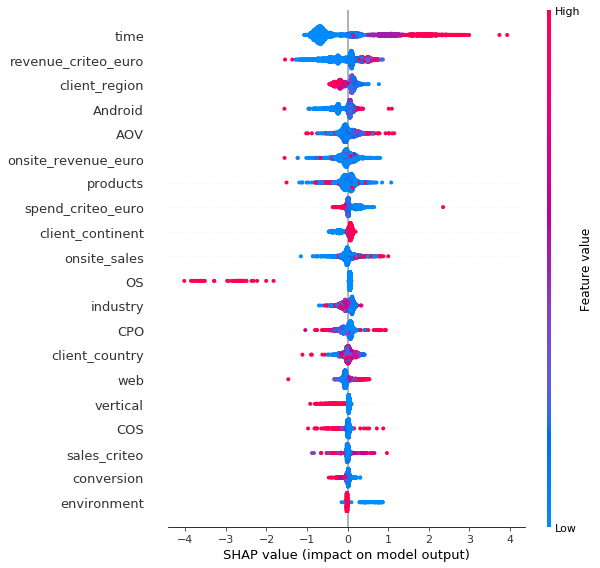

In [69]:
import shap
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_importance)
shap.summary_plot(shap_values, X_importance)

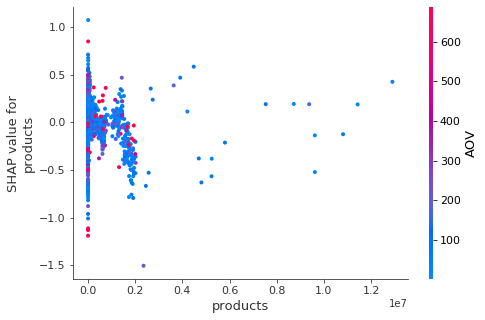

In [70]:
shap.dependence_plot("products", shap_values, X_test, alpha = 1)

## Now predict the churn date of top 3 clients which were excluded in the beginning with trained model

In [71]:
# save the model to disk
filename = 'churn_date_model.sav'
pickle.dump(xg_reg, open(filename, 'wb'))

In [72]:
model = pickle.load(open(filename, 'rb'))

[13:21:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [73]:
save_top3.columns

Index(['month', 'time', 'vertical', 'industry', 'client_country',
       'client_continent', 'client_region', 'OS', 'device', 'environment',
       'criteo_product', 'spend_criteo_euro', 'sales_criteo', 'CPO',
       'revenue_criteo_euro', 'AOV', 'COS', 'churn_date', 'Android', 'MacOS',
       'Other', 'iOs', 'Desktop', 'Mobile', 'app', 'web', 'awareness',
       'consideration', 'conversion', 'products', 'onsite_sales',
       'onsite_revenue_euro'],
      dtype='object')

In [74]:
save_top3['churn_date']

6082     0
14463    0
12587    0
Name: churn_date, dtype: int64

In [75]:
list(save_top3.columns)

['month',
 'time',
 'vertical',
 'industry',
 'client_country',
 'client_continent',
 'client_region',
 'OS',
 'device',
 'environment',
 'criteo_product',
 'spend_criteo_euro',
 'sales_criteo',
 'CPO',
 'revenue_criteo_euro',
 'AOV',
 'COS',
 'churn_date',
 'Android',
 'MacOS',
 'Other',
 'iOs',
 'Desktop',
 'Mobile',
 'app',
 'web',
 'awareness',
 'consideration',
 'conversion',
 'products',
 'onsite_sales',
 'onsite_revenue_euro']

In [76]:
list(X.columns)

['month',
 'time',
 'vertical',
 'industry',
 'client_country',
 'client_continent',
 'client_region',
 'OS',
 'device',
 'environment',
 'criteo_product',
 'spend_criteo_euro',
 'sales_criteo',
 'CPO',
 'revenue_criteo_euro',
 'AOV',
 'COS',
 'Android',
 'MacOS',
 'Other',
 'iOs',
 'Desktop',
 'Mobile',
 'app',
 'web',
 'awareness',
 'consideration',
 'conversion',
 'products',
 'onsite_sales',
 'onsite_revenue_euro']

In [77]:
X2 = save_top3.drop(columns=['churn_date'])
y2 = save_top3['churn_date']

# Prediction result for top 3 clients

In [84]:
pred_top3 = model.predict(X2)
get_final_date(pred_top3)

[(2021, 7), (2021, 3), (2021, 12)]